In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%%capture
!rm -rf x86_64
!nrnivmodl ../mechanisms

In [3]:
from neuron import h
h.load_file("stdrun.hoc");

In [4]:
from glob import glob

In [5]:
import json
from collections import OrderedDict

with open('../config/parameters.json') as fp:
    parameters = json.load(fp)
    
with open('./160118_c7_D1-protocols.json') as fp:
    protocols = json.load(fp, object_pairs_hook=OrderedDict)

In [6]:
iv_protocols = list(p for p in protocols if p.startswith('IV_')) + list(p for p in protocols if p.startswith('IV-supra_'))

In [7]:
sel_cell = 'Cell_8'
hoc = sel_cell + '.hoc'
h.load_file(hoc)
name = hoc.split('.')[0]
cmd = 'h.%s("../morphology/")' % name  # default morphology
cell = eval(cmd)
print(cmd)

h.Cell_8("../morphology/")


In [8]:
def run_protocol(prot, cell):
    stim0 = prot['stimuli'][0]
    stim1 = prot['stimuli'][1]
    h.v_init = -91.5
    h.celsius = 35
    h.tstop = stim0['totduration']
    
    hold = h.IClamp(cell.soma[0](0.5))
    hold.amp = stim1['amp']
    hold.delay = stim1['delay']
    hold.dur = stim1['duration']

    stim = h.IClamp(cell.soma[0](0.5))
    stim.amp = stim0['amp']
    stim.delay = stim0['delay']
    stim.dur = stim0['duration']
    
    time = h.Vector()
    volt = h.Vector()
    time.record(h._ref_t)
    volt.record(cell.soma[0](0.5)._ref_v)
    
    cvode = h.CVode()
    cvode.active(1)
    h.dt = 0.025
    h.run()

    return time, volt

In [9]:
traces = []
for proto in iv_protocols:
    print(proto)
    time, volt = run_protocol(protocols[proto], cell)
    traces.append({'time': list(time), 'volt': list(volt)})

IV_546
IV_547
IV_548
IV_549
IV_550
IV_551
IV_552
IV_553
IV_554
IV_555
IV_556
IV_557
IV-supra_558
IV-supra_559


In [10]:
Set1 = mpl.colormaps['Set1']
Pastel1 = mpl.colormaps['Pastel1']
mcolor = Set1(0.0)
hcolor = Set1(1.0 / 9)
mcolor_light = Pastel1(0.0)
hcolor_light = Pastel1(1.0 / 9)

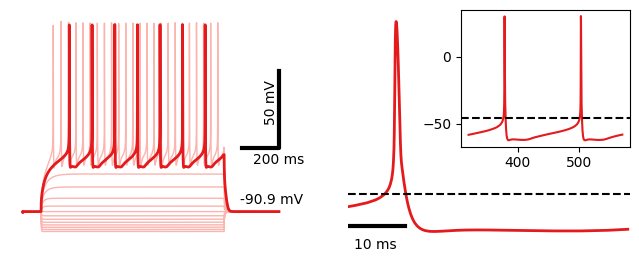

In [14]:
fig = plt.figure(figsize=(8, 3))

ax = fig.add_subplot(1, 2, 1)
for trace in traces:
    ax.plot(trace['time'], trace['volt'], color=mcolor_light, linewidth=1)
tr = traces[-2]
tr = {'time': np.array(tr['time']), 'volt': np.array(tr['volt'])}
ax.plot(tr['time'], tr['volt'], color=mcolor, linewidth=2)
vrest = np.mean(tr['volt'][-100:])
trest = np.mean(tr['time'][-100:])
tend = tr['time'][-1]
ax.text(trest - 70, vrest + 5, f'{vrest:.1f} mV')
ax.plot([tend - 200, tend, tend], [-50, -50, 0], color='black', linewidth=3)
ax.text(trest, -50 -10, '200 ms', ha='left')
ax.text(tend - 80, -50 +30, '50 mV', va='center', rotation=90)
ax.set_axis_off()

ax = fig.add_subplot(1, 2, 2)
apbegin = 370
apend = apbegin + 50
sel = (tr['time'] > apbegin) * (tr['time'] < apend)
t = tr['time'][sel]
v = tr['volt'][sel]
ax.plot(t, v, color=mcolor, linewidth=2)
ax.axhline(-46, color='black', linestyle='--')
#ax.text(apbegin - 3, -46 + 5, '-46 mV')

axin = ax.inset_axes([390, -25, 30, 60], transform=ax.transData)
selin = (tr['time'] > apbegin - 50) * (tr['time'] < apbegin+200)
tin = tr['time'][selin]
vin = tr['volt'][selin]
axin.plot(tin, vin, color=mcolor)
axin.axhline(-46, color='black', linestyle='--')
ax.plot([apbegin, apbegin+10], [-60, -60], color='black', linewidth=3)
ax.text(apbegin +1, -60 -10, '10 ms')

ax.set_xlim(apbegin, apend)
ax.set_axis_off()

In [12]:
exptraces = []
ljp = 11.5
for data in sorted(glob('../expdata/ECall_IV*ch3_*.dat')):
    d = np.loadtxt(data)
    exptraces.append({'time': d[:, 0], 'volt': d[:, 1] - ljp})

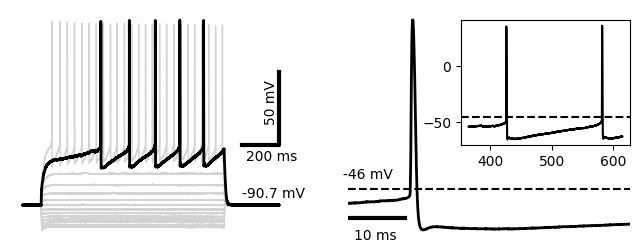

In [15]:
fig = plt.figure(figsize=(8, 3))

ax = fig.add_subplot(1, 2, 1)
for trace in exptraces:
    ax.plot(trace['time'], trace['volt'], color='lightgrey', linewidth=1)
tr = exptraces[-2]
ax.plot(tr['time'], tr['volt'], color='black', linewidth=2)
vrest = np.mean(tr['volt'][-2000:])
trest = np.mean(tr['time'][-2000:])
tend = tr['time'][-1]
ax.text(trest - 100, vrest + 5, f'{vrest:.1f} mV')
ax.plot([tend - 200, tend, tend], [-50, -50, 0], color='black', linewidth=3)
ax.text(trest - 80, -50 -10, '200 ms', ha='left')
ax.text(tend - 80, -50 +30, '50 mV', va='center', rotation=90)
ax.set_axis_off()
#apbegin=380
#ax.plot([apbegin, apbegin], [-100, 20], '--')
#ax.plot([apbegin+150, apbegin+150], [-100, 20], '--')

ax = fig.add_subplot(1, 2, 2)
apbegin = 415
apend = apbegin + 50
sel = (tr['time'] > apbegin) * (tr['time'] < apend)
t = tr['time'][sel]
v = tr['volt'][sel]
ax.plot(t, v, color='black', linewidth=2)
ax.axhline(-46, color='black', linestyle='--')
ax.text(apbegin - 1, -46 + 5, '-46 mV')

axin = ax.inset_axes([435, -25, 30, 60], transform=ax.transData)
selin = (tr['time'] > apbegin - 50) * (tr['time'] < apbegin+200)
tin = tr['time'][selin]
vin = tr['volt'][selin]
axin.plot(tin, vin, color='black')
axin.axhline(-46, color='black', linestyle='--')
ax.plot([apbegin, apbegin+10], [-60, -60], color='black', linewidth=3)
ax.text(apbegin +1, -60 -10, '10 ms')

ax.set_xlim(apbegin, apend)
ax.set_axis_off()